https://github.com/LorenzoVaralo/MNIST-from-Scratch/blob/main/MNISTalgorithm.ipynb

In [3]:
import numpy as np
import mnist_loader as ml
import time

In [4]:
training_data, validation_data, test_data = ml.load_data_wrapper()

In [5]:
a, b = zip(*training_data)
c, d = zip(*validation_data)
e, f = zip(*test_data)

a = np.array([x.reshape(784,) for x in a])
c = np.array([x.reshape(784,) for x in c])
e = np.array([x.reshape(784,) for x in e])

trainX = np.concatenate((a, c))
trainX = np.concatenate((np.ones([trainX.shape[0], 1]), trainX), axis=1)

b = np.array([y.reshape(10, ) for y in b])
cat = np.zeros([len(d), 10])
for i, y in enumerate(d):
    cat[i][y] = 1
d = cat

trainY = np.concatenate((b, d))

testX = np.concatenate((np.ones([e.shape[0], 1]), e), axis=1)

cat = np.zeros([len(d), 10])
for i, y in enumerate(f):
    cat[i][y] = 1
testY = cat

In [6]:
print(f'trainX: {trainX.shape}')
print(f'trainY: {trainY.shape}')
print(f'testX: {testX.shape}')
print(f'testY: {testY.shape}')

trainX: (60000, 785)
trainY: (60000, 10)
testX: (10000, 785)
testY: (10000, 10)


In [20]:
class Network:

    def __init__(self, sizes, activations, epochs=10, lr=0.1, batch=0):
        self.sizes = sizes
        self.activations = activations
        self.epochs = epochs
        self.lr = lr
        self.batch = batch
        self.weights = self.initWeights()

    def initWeights(self):
        weights = {f'W{layer+1}': np.random.randn(self.sizes[layer]+1, self.sizes[layer+1])/10 \
                   for layer in range(len(self.sizes)-1)}
        return weights
    
    def activ(self, x, activation):

        if activation == 'sigmoid':
            return 1/(1+np.exp(-x))
        
        elif activation == 'relu':
            return np.maximum(0, x)
        
        elif activation == 'softmax':
            # x = np.array(x)
            # e_x = np.exp(x - np.max(x))
            # return e_x / np.sum(e_x)
            x = np.array(x)
            e_x = np.exp(x - np.max(x, axis=1, keepdims=True))
            return (e_x / e_x.sum(axis=1)[:,None])
        
    def dactiv(self, x, activation):

        if activation == 'sigmoid':
            return np.multiply(self.activ(x, 'sigmoid'), (1 - self.activ(x, 'sigmoid')))
        
        elif activation == 'relu':
            return np.where(x >= 0, 1, 0)
        
    def forwardPass(self, X):

        X = np.matrix(X)
        M = X.shape[0]
        last = len(self.sizes)
        FPsteps = {'a1': X}

        for layer in range(1, last):
            activation = self.activations[layer-1]
            FPsteps[f'z{layer+1}'] = FPsteps[f'a{layer}'] @ self.weights[f'W{layer}']
            FPsteps[f'a{layer+1}'] = np.concatenate((np.ones([M,1]), self.activ(FPsteps[f'z{layer+1}'], activation)), axis=1)

        h = FPsteps.pop(f'a{last}')
        FPsteps['h'] = h[:,1:]

        return FPsteps
    
    def dLdW(self, X, Y):

        X = np.matrix(X)
        Y = np.matrix(Y)
        M = X.shape[0]
        nLayers = len(self.sizes)
        gradients = []
        FPsteps = self.forwardPass(X)

        deltas = {f'delta{nLayers}': FPsteps['h'] - Y} # delta for last layer
        for i in range(nLayers-1, 1, -1):
            deltas[f'delta{i}'] = np.multiply((deltas[f'delta{i+1}'] @ self.weights[f'W{i}'][1:].T), \
                self.dactiv(FPsteps[f'z{i}'], self.activations[i-2]))

        # gradients = [(deltas[f'delta{i+2}'].T @ FPsteps[f'a{i+1}']) / M for i in range(len(deltas))]

        for i in range(len(deltas)):
            Delta = np.array(deltas[f'delta{i+2}'].T @ FPsteps[f'a{i+1}'])
            gradients.append(Delta / M)

        return gradients
    
    def accuracy(self, X, Y):

        Forward_list = self.forwardPass(X)
        h = Forward_list['h']
        y_hat = np.argmax(h, axis=1)[:,None]
        y = np.argmax(Y, axis=1)[:,None]
        return np.mean(y_hat == y)
    
    def train(self, xTrain, yTrain, xTest, yTest):

        M = xTrain.shape[0]

        for epoch in range(self.epochs):
            slicer = np.array([0, self.batch])

            for i in range(M // self.batch): # backPropagation
                batch = slicer + i*self.batch
                gradients = self.dLdW(xTrain[batch[0]:batch[1]], yTrain[batch[0]:batch[1]])
                newWeights = {f'W{j+1}': self.weights[f'W{j+1}'] - self.lr*np.array(gradients[j]).T \
                              for j in range(len(gradients))}
                self.weights.update(newWeights)
            
            accTrain = self.accuracy(xTrain, yTrain)
            accTest = self.accuracy(xTest, yTest)

            print(f'Epoch: {epoch+1}; Accuracy Train: {accTrain}; Accuracy Test: {accTest}')



In [21]:
N = Network([784, 200, 80, 10], ['relu', 'sigmoid', 'softmax'], epochs=10, lr=0.1, batch=1000)

In [22]:
N.train(trainX, trainY, testX, testY)

C:\Users\majchrza\AppData\Local\Temp\ipykernel_7724\2289530762.py:19: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-x))


Epoch: 1; Accuracy Train: 0.11236666666666667; Accuracy Test: 0.1135
Epoch: 2; Accuracy Train: 0.09915; Accuracy Test: 0.1009
Epoch: 3; Accuracy Train: 0.09751666666666667; Accuracy Test: 0.0974
Epoch: 4; Accuracy Train: 0.09915; Accuracy Test: 0.1009
Epoch: 5; Accuracy Train: 0.09863333333333334; Accuracy Test: 0.0958


KeyboardInterrupt: 

In [23]:
class MNISTalgorithm:
    def __init__(self, estrutura, epochs=10, alpha=0.1, batch_size=0, Regularizer=0.0):
        self.tamanhos = [x for x in estrutura if isinstance(x, int)]
        self.ativações = [x.lower() for x in estrutura if isinstance(x, str)]
        self.inputs = [epochs,alpha,batch_size,Regularizer]
        self.epochs = epochs
        self.alpha = alpha
        self.Reg = Regularizer
        self.batch_size = batch_size
        self.Thetas = self.Inicialização()
        self.CheckInputs()
    

    def CheckInputs(self): #Aviso de possiveis erros
        assert isinstance(self.epochs,int), 'ERRO: parametro "epochs" deve ser integer.'
        assert isinstance(self.alpha,float), 'ERRO: parametro "alpha" deve ser float.'
        assert isinstance(self.batch_size,int), 'ERRO: parametro "batch_size" deve ser integer.'
        assert isinstance(self.Reg,float), 'ERRO: parametro "Regularizer" deve ser float.'
        assert (self.tamanhos[0] == 784) and (self.tamanhos[-1] == 10),'ERRO: A primeira camada deve ter 784 neurônios e a ultima 10 neurônios.'
        assert len(self.ativações) == (len(self.tamanhos)-1), 'ERRO: Quantidade de camadas e ativações incompatível.'
        assert self.ativações[-1] == 'softmax', 'ERRO: A ultima ativação deve ser Softmax.'


    def Inicialização(self):# Inicializando Weights e Bias aleatoriamente
        Thetas = {}
        for layer in range(len(self.tamanhos)-1):
            Thetas[f'T{layer+1}'] = np.random.randn(self.tamanhos[layer]+1, self.tamanhos[layer+1])/10
        return Thetas


    def sigmoid(self, z):
        return 1/(1 + np.exp(-z))

    def dxsigmoid(self, z):
        return np.multiply(self.sigmoid(z),(1-self.sigmoid(z)))

    def softmax(self,x):
        x = np.array(x)
        e_x = np.exp(x - np.max(x, axis=1, keepdims=True))
        return (e_x / e_x.sum(axis=1)[:,None])

    def Relu(self, x):
        return np.maximum(0,x)
    
    def dxRelu(self, x):
        return np.where(x >= 0, 1, 0)
    

    def Forward(self,X):
        '''Adicionando todo processo da Forward Propagation em um dicionario
        {"a1": [...], "z2": [...], "a2": [...], "z3": [...], ..... ,"h":[...]}'''
        X = np.matrix(X)
        m = X.shape[0]
        att = self.ativações
        Thetas = self.Thetas
        Forward_steps = {}
        Forward_steps['a1'] = X
        Ultimo_layer = int(len(self.tamanhos))
        for layer in range(1,Ultimo_layer):
            Forward_steps[f'z{layer+1}'] = np.dot(Forward_steps[f'a{layer}'], Thetas[f'T{layer}'])
            if att[layer-1] == 'sigmoid':
                Forward_steps[f'a{layer+1}'] = np.concatenate((np.ones([m,1]), self.sigmoid(Forward_steps[f'z{layer+1}'])), axis=1)
            elif att[layer-1] == 'softmax':
                Forward_steps[f'a{layer+1}'] = np.concatenate((np.ones([m,1]), self.softmax(Forward_steps[f'z{layer+1}'])), axis=1)
            elif att[layer-1] == 'relu':
                Forward_steps[f'a{layer+1}'] = np.concatenate((np.ones([m,1]), self.Relu(Forward_steps[f'z{layer+1}'])), axis=1)
            else:
                print('ERRO NAS ATIVAÇÕES')

        
        h = Forward_steps.pop(f'a{Ultimo_layer}')
        Forward_steps['h'] = h[:,1:]
        
        return Forward_steps
        

    def CostFunction(self):
        '''É calculado a logistic Cost Function para todas as classes(10) e todas as rows(59500)'''
        Y = self.Y
        X = self.X
        Thetas = self.Thetas
        m = self.m
        Reg = self.Reg
        soma_weights = 0
        for i in range(len(Thetas)):
            weights = Thetas[f'T{i+1}']
            weights[0] = 0
            soma_weights += np.sum(weights**2)
        Forward_dict = self.Forward(X)
        h = Forward_dict['h']
        soma = np.sum((np.multiply(-Y , np.log(h)) - np.multiply((1-Y),(np.log(1-h)))))
        J = soma/m + (Reg/(2*m)) * soma_weights
        return J


    def Gradients(self,X,Y):
        '''Calcular a derivada de todos Thetas w.r.t Cost function, 
        é organizado utilizando um dicionario contendo os deltas.
        {...., "delta2": [...], "delta1": [...]}'''
        X = np.matrix(X)
        Y = np.matrix(Y)
        m = X.shape[0]
        Thetas = self.Thetas
        n_layers = len(self.tamanhos)
        att = self.ativações
        Thetas_grad = []

        Forward_list = self.Forward(X)
        deltas = {}
        deltas[f'delta{n_layers}'] = Forward_list['h'] - Y # delta4
        for i in range(n_layers-1,1,-1):# 3 ... 2
            if att[i-2] == 'sigmoid':
                deltas[f'delta{i}'] = np.multiply((np.dot(deltas[f'delta{i+1}'],Thetas[f'T{i}'][1:].T)) , self.dxsigmoid(Forward_list[f'z{i}']))
            elif att[i-2] == 'relu':
                deltas[f'delta{i}'] = np.multiply((np.dot(deltas[f'delta{i+1}'],Thetas[f'T{i}'][1:].T)) , self.dxRelu(Forward_list[f'z{i}']))
        
        for c in range(len(deltas)):#0 ... 1 ... 2
            BigDelta = np.array(np.dot(deltas[f'delta{c+2}'].T, Forward_list[f'a{c+1}']))
            weights = Thetas[f'T{c+1}']
            weights[0] = 0 #Coluna dos bias vira 0's
            grad = np.array(BigDelta + (self.Reg * weights.T))/m
            Thetas_grad.append(grad)
        return Thetas_grad #[T1_grad, T2_grad, T3_grad]


    def Precisao(self, X,Y):
        '''É calculado a porcentagem em que o algoritmo classificou corretamente a imagem.'''
        Forward_list = self.Forward(X)
        h = Forward_list['h']
        y_hat = np.argmax(h, axis=1)[:,None]
        y = np.argmax(Y, axis=1)[:,None]
        return np.mean(y_hat == y)


    def train(self, X, Y,x_test,y_test):
        '''Função que organiza os precessos para o aprendizado adequedo, utilizando os parametros inseridos.
        Após <num> epochs, é feito o calculo do Cost, calculo da precisão em relação ao Treinamento e ao 
        Teste(provando sua capacidade de generalizar).'''
        Thetas = self.Thetas
        self.X = X
        self.Y = Y
        self.m = X.shape[0]
        j_history = []
        sec1 = time.time()
        if self.batch_size <= 0:
            b_size = self.m
            print(f'Usando batch de tamanho {b_size}..')
        elif isinstance(self.batch_size, int) and (1<= self.batch_size <= self.m):
            b_size = self.batch_size
        else:
            return 'ERRO EM BATCH_SIZE'
        for ep in range(self.epochs):
            m = self.m
            a = np.array([0,b_size])
            num = 1 #Coloque um numero maior se utilizar muitas epochs
            
            for i in range(m // b_size):
                inx = a + b_size*i
                grad_list = self.Gradients(X[inx[0]:inx[1]], Y[inx[0]:inx[1]])
                for g in range(len(grad_list)):
                    self.Thetas[f'T{g+1}'] = self.Thetas[f'T{g+1}'] - self.alpha*np.array(grad_list[g]).T
            
            if (ep+1) % num == 0: #
                J = self.CostFunction()
                j_history.append(J)
                accu_train = self.Precisao(X,Y)
                accu_test = self.Precisao(x_test,y_test)
                sec2 = time.time()
                tempo_gasto = sec2 - sec1
                print(f'Epoch: {ep+1}; Cost: {J:.5f}: Accuracy Train: {accu_train:.5%}; Accuracy Test: {accu_test:.5%}; Tempo Gasto: {tempo_gasto:.2f} s')
        return j_history, self.Thetas

In [24]:
model = MNISTalgorithm([784, 'relu', 200,'sigmoid',80, 'softmax', 10], epochs=10, alpha=0.1, batch_size=0)

In [25]:
j_history, trained_thetas = model.train(trainX,trainY,testX,testY)

Usando batch de tamanho 60000..
Epoch: 1; Cost: 3.34797: Accuracy Train: 11.83833%; Accuracy Test: 12.14000%; Tempo Gasto: 5.56 s
Epoch: 2; Cost: 3.29734: Accuracy Train: 13.07000%; Accuracy Test: 13.33000%; Tempo Gasto: 10.57 s
Epoch: 3; Cost: 3.26320: Accuracy Train: 14.03500%; Accuracy Test: 14.01000%; Tempo Gasto: 15.47 s
Epoch: 4; Cost: 3.23842: Accuracy Train: 15.11000%; Accuracy Test: 14.67000%; Tempo Gasto: 20.42 s
Epoch: 5; Cost: 3.21931: Accuracy Train: 16.30500%; Accuracy Test: 16.02000%; Tempo Gasto: 25.56 s
Epoch: 6; Cost: 3.20365: Accuracy Train: 17.47333%; Accuracy Test: 17.24000%; Tempo Gasto: 30.62 s
Epoch: 7; Cost: 3.19010: Accuracy Train: 19.30500%; Accuracy Test: 19.14000%; Tempo Gasto: 35.50 s
Epoch: 8; Cost: 3.17783: Accuracy Train: 22.07500%; Accuracy Test: 21.79000%; Tempo Gasto: 40.24 s
Epoch: 9; Cost: 3.16631: Accuracy Train: 24.93333%; Accuracy Test: 24.84000%; Tempo Gasto: 44.99 s
Epoch: 10; Cost: 3.15524: Accuracy Train: 27.45000%; Accuracy Test: 27.29000%;

In [88]:
def softmax(x):
        x = np.array(x)
        e_x = np.exp(x - np.max(x, axis=1, keepdims=True))
        return (e_x / e_x.sum(axis=1)[:,None])

In [118]:
def softmax2(x):
        x = np.array(x)
        e_x = np.exp(x - np.max(x))
        return e_x / np.sum(e_x)

In [120]:
softmax(np.matrix(trainX[0])).shape

(1, 785)

In [121]:
softmax2(np.matrix(trainX[0])).shape

(1, 785)

In [100]:
np.matrix(trainX[0]).shape

(1, 785)

In [25]:
check = {'dupa': 1, 'dupa2': 2, 'dupa3':3}
check2 = {'dupa2': 4}

In [26]:
check['lalal'] = 6

In [27]:
check

{'dupa': 1, 'dupa2': 2, 'dupa3': 3, 'lalal': 6}

In [134]:
trainX[dupa[0]:dupa[1]].shape

(1000, 785)

In [135]:
np.matrix(trainX[dupa[0]:dupa[1]]).shape

(1000, 785)

In [141]:
np.argmax(trainY[0])

5

In [133]:
50000%10000

0

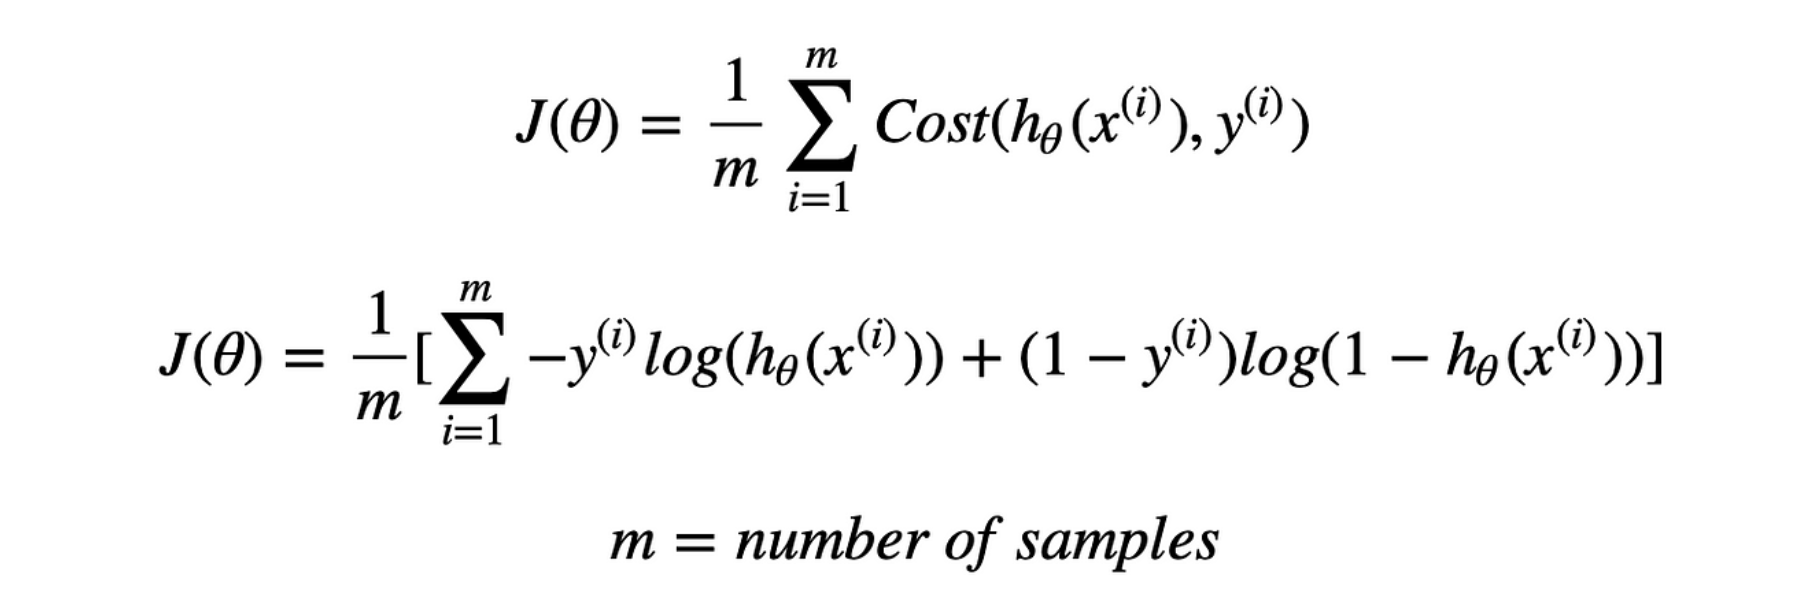